<a href="https://colab.research.google.com/github/jcvincentliu/MACS-31300-Project-Diving-into-NYT-Articles-in-Four-Years/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **MACS 31300: Final Project - Public Policies and Public Opinions Behind New York Times News Articles in Four Years**
####  --- Uncovering the myths of news through the use of natural language processing, clustering, and deep learning

In this project, I dug into how the magnitude of crime-related news among public in the last 50 years by exploring the [New York Times Archives news data](https://developer.nytimes.com/). As we can tell from the official crime data, on a nationwide level, crime levels rose in the 70s and 80s, peaked in the early 90s and have been dropping since mid-90s. This is especially the pattern for violent crimes. Public policies, however, did not quite fit into this pattern that we saw important crime prevention policies becoming the law all the time and that with lower crime levels, the trend was fighting harder on crimes. One explanation in the literature is changes in crime policies are in responce with the public opinion and attitudes on crimes in lieu of what is really going on. The approach highlights the political influence of public opinion while giving attention to how the electrocal system works in the country. I am intersted in knowing about the validity of the latter explantion. 

The project was made a possibility with a mix of methods, including natural language processing and clustering. I started with cleaning the data, applying necessary transformations, moving to exploratory analysis of the most salient tuples in each decade, and ending with using machine learning to fina out the best model.   

### **Project Description**

---



The whole project will be divided into five phases. In phases one and two, I scrape the data from the New York Times archive database and perform data wrangling including cleaning the text data, tokenizing them, and generating concatenated tables. I will be giving my attentions to NYT articles in four specific years, 1971, 1989, 2010, and 2020, each of which is represented with an influential criminal justice policy/legislation. In phrase three, I did explorative data analysis (EDA) by looking at most frequent words and bigrams and creating visualizations. In phrase four, I use clustering techniques to divide tokens into groups and visualizing the grouping. Lastly, I will project the groups using deep learning methods to create interactive visualizations. 

Starting with loading `request`, `nltk`, `tensorflow`, `sklearn`, and other libraries. We will also be loading other libraries along the way to support out tasks. 

In [4]:
import nltk
nltk.download('stopwords')
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
from nltk.corpus import stopwords
nltk.download("stopwords") #provides list of english stopwords
stop = stopwords.words('english')  

import requests
import json
import seaborn as sns
import re
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
os.getcwd() # get current directory, shall be deleted later   see https://note.nkmk.me/en/python-os-getcwd-chdir/


'/'

In [ ]:
os.chdir("/..") # delete later

### Part I: Gathering Data Through Web Scraping (Preliminary Data Collection)
---

The codes are adapted from a [Hackaton competition on Kaggle](https://www.kaggle.com/code/tumanovalexander/nyt-dataset-hackaton/notebook). Since the original scope of my analysis was all articles published by New York Times between 1960-2020, I scraped each year's data and concatenated them into one large data frame.   

In [ ]:
df_archieve = {}

for year in range(1960, 2021):
    archieve = []
    for month in range(1, 13):
        articles_request = requests.get(f'https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key=8Aekv3zl5FZVAoZwAGfwAn4BO1ruYxh2')
        if articles_request.ok:
            articles_content = json.loads(articles_request.text)
            number_of_news_items = len(articles_content['response']['docs'])

            for i in range(number_of_news_items):
                if 'abstract' in articles_content['response']['docs'][i].keys():
                    fragment_abstract = articles_content['response']['docs'][i]['abstract']
                    fragment_headline = articles_content['response']['docs'][i]['headline']['main']
                    if fragment_abstract or fragment_headline:
                        fragment = fragment_abstract + ' ' + fragment_headline
                    archieve.append(fragment)
                    
    df_archieve = pd.DataFrame(data=archieve, index=np.full_like(range(len(archieve)), year)).reset_index()
    df_archieve.rename(columns={'index': 'year', 0: 'sentence'}, inplace=True)
    df_archieve.to_csv(f'datasets\df_{year}.csv')

In [ ]:
year_archieves = pd.DataFrame()

for year in range(1960, 2021):
    df = pd.read_csv(f'datasets\df_{year}.csv')
    year_archieves = pd.concat([year_archieves, df])

I saved the data into my local environment.



In [ ]:
year_archieves.to_csv('Total Archives.csv')

### Part II: Cleaning the Text Data
---

Loading the data of years 1971, 1989, 2010, and 2020:

In [ ]:
from google.colab import files
uploaded = files.upload()

In [7]:
NYT_1971 = pd.read_csv("df_1971.csv") # Beginning of war on drug: https://www.britannica.com/topic/war-on-drugs

NYT_1989 = pd.read_csv("df_1989.csv") # influential Connor vs Graham

NYT_2010 = pd.read_csv("df_2010.csv") # the peak of incarceration counts in the nation, see the graph on https://www.prisonpolicy.org/profiles/US.html#time

NYT_2020 = pd.read_csv("df_2020.csv") # Killing of George Floyd

I created a function that does five things: stripping each sentence into strings, converting words into lower case, removing stopwords, punctuations, and numbers, processing missing data, and reformatting `year` as a factor/categorical variable. As contrast to a standard data cleaning pipeline, I am also removing words that has only one or two characters in length to make our frequency counting process more easy-to-understand because naturally, words that are one or two characters in length add little to the holistic understanding of the text. I applied the function to four datasets.

In [8]:
def clean_data(NYT_df):
  NYT_df.drop(columns=['Unnamed: 0'], inplace=True)
  NYT_df['sentence processed'] = NYT_df["sentence"].str.lower() # lowercase every string
  NYT_df['sentence processed'] = NYT_df['sentence processed'].apply(lambda x: re.sub(r'\d+', '', x)) # remove all the numbers
  NYT_df['sentence processed'] = NYT_df['sentence processed'].apply(lambda x: re.compile(r'<[^>]+>').sub(" ", x)) 
  NYT_df['sentence processed'] = NYT_df['sentence processed'].apply(lambda x: re.compile(r'\W*\b\w{1,2}\b').sub(" ", x))  # remove words with only 1-2 characters
  NYT_df['sentence processed'] = NYT_df['sentence processed'].apply(lambda x: re.sub(r'[^\w\s]',' ',x)) # remove punctuation
  NYT_df['sentence processed'] = NYT_df['sentence processed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # remove stop words
  NYT_df['sentence processed'] = NYT_df["sentence processed"].fillna("fillna") # fill NA with fillna
  NYT_df["year"] = NYT_df["year"].astype("category")
  return NYT_df

In [9]:
NYT_1971 = clean_data(NYT_1971)
NYT_1989 = clean_data(NYT_1989)
NYT_2010 = clean_data(NYT_2010)
NYT_2020 = clean_data(NYT_2020)


By inspecting the first five rows of the dataset `NYT_1971`, I was able to grasp a sense of what my data looks like. This is important for future analysis. I also realized that all variables with the exception of `year` are in the pandas object type.   

In [ ]:
NYT_1971.dtypes

year                  category
sentence                object
sentence processed      object
dtype: object

In [ ]:
NYT_1971.head()

,year,sentence,sentence processed
0,1971,A Moursund Jr lr on T Winner's Dec 22 (32:4) l...,moursund winner dec disputes winner suggestion...
1,1971,Amer Gas Assn repts gas utility and pipeline i...,amer gas assn repts gas utility pipeline indus...
2,1971,Dr Spock lr disputes Prof Bickel Dec 21 Op-Ed ...,spock disputes prof bickel dec article attacki...
3,1971,Northfield Savings Bank begins operation under...,northfield savings bank begins operation new n...
4,1971,"NYS Health Dept repts 638,077 children, 26.4% ...",nys health dept repts children population aged...


For this project, I am concerned with both individual words and bigrams (two words as a group). 

- Token/Unigram: 

Single words may have particular meanings in English. To understand this, thinking about the word "criminal", which itself tells us a lot of information. With this word, we are able to picture an image of someone committing an unlawful act, A single word could have sentiment and be used to shed light on public opinion. 

In the first step, I tokenized each article in each dataset and put the list of tokens in a new column named `sentence tokenized`. 

In [10]:
NYT_1971["sentence tokenized"] = NYT_1971["sentence processed"].str.split(' ')
NYT_1989["sentence tokenized"] = NYT_1989["sentence processed"].str.split(' ')
NYT_2010["sentence tokenized"] = NYT_2010["sentence processed"].str.split(' ')
NYT_2020["sentence tokenized"] = NYT_2020["sentence processed"].str.split(' ')

- Bigram

Words come in pairs usually reveal more information than single words. Still using the example of "criminal", phrases "criminal justice" and "criminal sentencing" go to two distinct directions, although they both share the word "criminal". The former could mean a field of study or a principle, whereas, the latter is a judicial and legislative term. Hereby, diving words into bigrams will give us more information about the data.

In the following two chunks, I created a function that will rearrange a list of single tokens into a list of bigrams and apply it to our datasets. The new column is called `sentence tokenized`.

In [11]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [12]:
NYT_1971['sentence bigrammed'] = NYT_1971['sentence tokenized'].apply(ngrams)
NYT_1989['sentence bigrammed'] = NYT_1989['sentence tokenized'].apply(ngrams)
NYT_2010['sentence bigrammed'] = NYT_2010['sentence tokenized'].apply(ngrams) # remove all the numbers
NYT_2020['sentence bigrammed'] = NYT_2020['sentence tokenized'].apply(ngrams)

Now, let's take another look at our `NYT_1971` data. 

In [11]:
NYT_1971.head(5)

,year,sentence,sentence processed,sentence tokenized,sentence bigrammed
0,1971,A Moursund Jr lr on T Winner's Dec 22 (32:4) l...,moursund winner dec disputes winner suggestion...,"[moursund, winner, dec, disputes, winner, sugg...","[moursund winner, winner dec, dec disputes, di..."
1,1971,Amer Gas Assn repts gas utility and pipeline i...,amer gas assn repts gas utility pipeline indus...,"[amer, gas, assn, repts, gas, utility, pipelin...","[amer gas, gas assn, assn repts, repts gas, ga..."
2,1971,Dr Spock lr disputes Prof Bickel Dec 21 Op-Ed ...,spock disputes prof bickel dec article attacki...,"[spock, disputes, prof, bickel, dec, article, ...","[spock disputes, disputes prof, prof bickel, b..."
3,1971,Northfield Savings Bank begins operation under...,northfield savings bank begins operation new n...,"[northfield, savings, bank, begins, operation,...","[northfield savings, savings bank, bank begins..."
4,1971,"NYS Health Dept repts 638,077 children, 26.4% ...",nys health dept repts children population aged...,"[nys, health, dept, repts, children, populatio...","[nys health, health dept, dept repts, repts ch..."


One of my goal in this section is to map the most popular words/grams in NYT articles and draw time series graphs to display the usage of words of NYT writers over time. To do that, I started with making a function that compiles tokens and bigrams into one single list. I then rearranged my data into a pandas dataframe with this function. This function has four rows and five attributes/columns - `year`, `Tokens`, `Num of Tokens`, `Bigrams`, and `Num of Bigrams`.

This is done below:

In [ ]:
def get_word_lists_nyt(NYT_df):
  wordlist_nyt = []
  num_article_yr = NYT_df.shape[0]
  for num in range(num_article_yr):
    words = NYT_df["sentence tokenized"][num]
    for word in words:
      wordlist_nyt.append(word)
  return wordlist_nyt

def get_bigram_lists_nyt(NYT_df):
  wordlist_nyt = []
  num_article_yr = NYT_df.shape[0]
  for num in range(num_article_yr):
    words = NYT_df["sentence bigrammed"][num]
    for word in words:
      wordlist_nyt.append(word)
  return wordlist_nyt

In [ ]:
wordlist_nyt_1971 = get_word_lists_nyt(NYT_1971)
wordlist_nyt_1989 = get_word_lists_nyt(NYT_1989)
wordlist_nyt_2010 = get_word_lists_nyt(NYT_2010)
wordlist_nyt_2020 = get_word_lists_nyt(NYT_2020)


In [ ]:
bigramlist_nyt_1971 = get_bigram_lists_nyt(NYT_1971)
bigramlist_nyt_1989 = get_bigram_lists_nyt(NYT_1989)
bigramlist_nyt_2010 = get_bigram_lists_nyt(NYT_2010)
bigramlist_nyt_2020 = get_bigram_lists_nyt(NYT_2020)

In [ ]:
NYT_token_dict = {"Year": ["1971", "1989", "2010", "2020"], 
                  "Tokens": [wordlist_nyt_1971, wordlist_nyt_1989, wordlist_nyt_2010, wordlist_nyt_2020], 
                  "Num of Tokens": [len(wordlist_nyt_1971), len(wordlist_nyt_1989), len(wordlist_nyt_2010), len(wordlist_nyt_2020)], 
                  "Bigrams": [bigramlist_nyt_1971, bigramlist_nyt_1989, bigramlist_nyt_2010, bigramlist_nyt_2020], 
                  "Num of Bigrams": [len(bigramlist_nyt_1971), len(bigramlist_nyt_1989), len(bigramlist_nyt_2010), len(bigramlist_nyt_2020)]}
NYT_tokens = pd.DataFrame(data= NYT_token_dict)
NYT_tokens["Year"] = NYT_tokens["Year"].astype("category")


In [ ]:
NYT_tokens.dtypes

Year              category
Tokens              object
Num of Tokens        int64
Bigrams             object
Num of Bigrams       int64
dtype: object

Notice that year 1971 has an index of 0, which follows "Pythonic" way of indexing. Moreover, the year 2020 has significantly less articles than the above years 1971, 1989, and 2010. This may because either NYT published fewer articles in 2020 because of covid or some other reasons or that the database is incomplete in the sense that NYT only collected articles up to a certain month in 2020. I have no idea which one is accurate, but this may pose questions on validity of our future analysis.

In [ ]:
NYT_tokens

,Year,Tokens,Num of Tokens,Bigrams,Num of Bigrams
0,1971,"[moursund, winner, dec, disputes, winner, sugg...",2569523,"[moursund winner, winner dec, dec disputes, di...",2476133
1,1989,"[lead, editor, bah, humbug, lead, chile, milit...",2862803,"[lead editor, editor bah, bah humbug, lead chi...",2758272
2,2010,"[age, digital, imagery, one, man, still, earns...",1983852,"[age digital, digital imagery, imagery one, on...",1871404
3,2020,"[president, terrible, toddler, anyone, else, w...",273005,"[president terrible, terrible toddler, toddler...",258480


### Part III: Exploring Data with Explorative Data Analysis (EDA)
---



In part 2, I have performed preliminary data cleaning and processing. In this section, I will be using summary statistics (Python's `collections` library) and visualizations (wordmaps, bar charts, and line graphs) to further harvest what's behind our NYT data. 

First of all, load the `collections` library, which provides a fast way of counting objects. With this library, we can easily discover the most frequent words and bigrams at each of these four time points. We generated 8 frequency tables, 4 for tokens, 4 for bigrams, and 2 for each year.

In [ ]:
from collections import Counter
count_word_nyt1971 = Counter(wordlist_nyt_1971)
count_word_nyt1989 = Counter(wordlist_nyt_1989)
count_word_nyt2010 = Counter(wordlist_nyt_2010)
count_word_nyt2020 = Counter(wordlist_nyt_2020)

count_bigram_nyt1971 = Counter(bigramlist_nyt_1971)
count_bigram_nyt1989 = Counter(bigramlist_nyt_1989)
count_bigram_nyt2010 = Counter(bigramlist_nyt_2010)
count_bigram_nyt2020 = Counter(bigramlist_nyt_2020)

After inspecting the most common 20 words in 1971, I noticed that a lot of words on this list are nouns that don't add to values, for examples, words "new", "york", "times" pop up frequenly simply because they are on the name of the journal. Moreover, the popularity of words "days", "news", "weeks", "first" and alike may come from the idiosyncrasy of journalists. I will be defining these words as stopwords to be removed from our plotting. 

In [ ]:
count_word_nyt1971.most_common(20)

[('says', 16531),
 ('new', 14766),
 ('today', 8378),
 ('city', 7453),
 ('state', 7212),
 ('illus', 6972),
 ('nixon', 6696),
 ('mrs', 6343),
 ('million', 6153),
 ('article', 5797),
 ('would', 5573),
 ('pres', 5302),
 ('govt', 5215),
 ('last', 4936),
 ('may', 4839),
 ('nyc', 4679),
 ('york', 4353),
 ('yesterday', 4131),
 ('first', 3981),
 ('fed', 3957)]

In [ ]:
stop_lst = ['new', 'york', 'times', 'says', 'today', 'article', 'said', 'would', 'first', 'two', 'week', 'world', 'state', 'one', 'day', 'year', 'may', 'mrs', 'city', 'com',
            'last', 'three']
            
stop_lst2 = ["letters editor", "article title", "year old", "last night", "last week", "daughter mrs", "years old", "son mrs", "daughter miss", "years old ", "lead editor"
              "qtr march", "qtr june", "qtr dec", "qtr sept", 
              "first time", "see full", "york times"]

In [ ]:
def make_count_df(nyt_counter):
    freq_df = pd.DataFrame.from_dict(nyt_counter, orient='index', columns=['Count'])
    freq_df = freq_df.query('Count >= 100')
    freq_df.index.name = 'Token'
    return freq_df.sort_values('Count', ascending=False)


In [ ]:
freq_word_1971 = make_count_df(count_word_nyt1971)
freq_word_1989 = make_count_df(count_word_nyt1989)
freq_word_2010 = make_count_df(count_word_nyt2010)
freq_word_2020 = make_count_df(count_word_nyt2020)

freq_bigram_1971 = make_count_df(count_bigram_nyt1971)
freq_bigram_1989 = make_count_df(count_bigram_nyt1989)
freq_bigram_2010 = make_count_df(count_bigram_nyt2010)
freq_bigram_2020 = make_count_df(count_bigram_nyt2020)


#### Wordclouds - What words and phrases were trending?

With these stop words in mind, now let's make word clouds. Word cloud is a visual way to present the frequency table through the use of layouts, sizes, and shapes. The `WordCloud` library in Python provides an easy way to create word cloud maps. The self-defined `wordcloud` function below creates word cloud that allows the removal of stopwords in counting as well as resets background color, use different design, and manipulate other features. 

In [ ]:
from wordcloud import WordCloud
from matplotlib.gridspec import GridSpec

def wordcloud(word_freq, title=None, max_words=200, stopwords=None, background_color = "black", colormap = "tab20c"):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="tab20c", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}

    wc.generate_from_frequencies(counter)
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


First making wordclouds of the most popular single words to use in NYT articles in four years. From the grid below, we are able to say in 1971, words such as "nixon", "military", and "govt" were popular. In year 1989, financial/business terms like "earnings", "company", "share", "inc" went trending. In years 2010 and 2020, NYT followed closely with what was evolving on the Capital Hill and its reports had more political words. Across these four time points, we found out that national politics has been the top 1 topic that NYT writers cared about. 

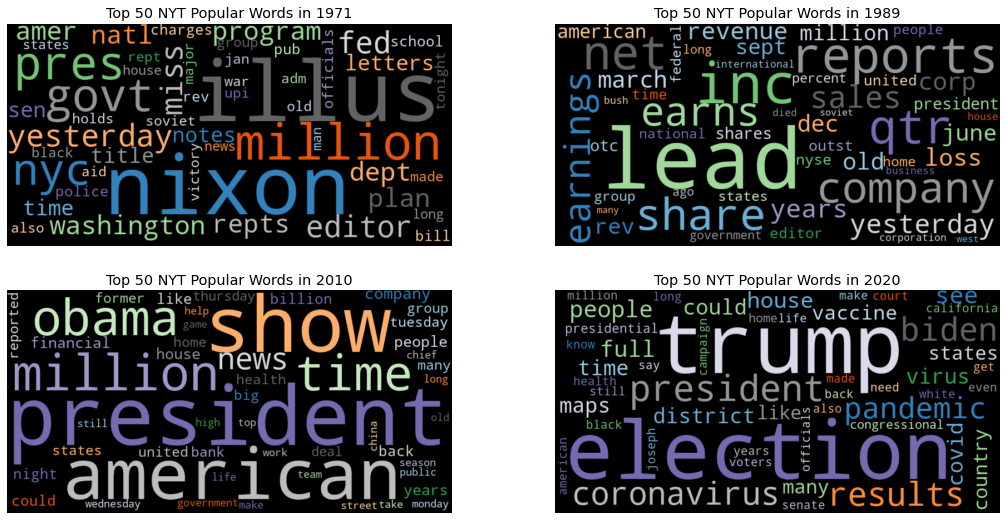

In [ ]:
plt.figure(figsize=(18,9)) ###

plt.subplot(2,2,1)  #nrows, ncols, index
wordcloud(count_word_nyt1971, title='Top 50 NYT Popular Words in 1971', max_words=50, stopwords = stop_lst)
plt.savefig("wordcloudNYT1971")

plt.subplot(2,2,2)  #nrows, ncols, index
wordcloud(count_word_nyt1989, title='Top 50 NYT Popular Words in 1989', max_words=50, background_color = "black", stopwords = stop_lst)
plt.savefig("wordcloudNYT1989")

plt.subplot(2,2,3)  #nrows, ncols, index
wordcloud(count_word_nyt2010, title='Top 50 NYT Popular Words in 2010', max_words=50, background_color = "black", colormap="Paired", stopwords = stop_lst)
plt.savefig("wordcloudNYT2010")

plt.subplot(2,2,4)  #nrows, ncols, index
wordcloud(count_word_nyt2020, title='Top 50 NYT Popular Words in 2020', max_words=50, background_color = "black", stopwords = stop_lst)
plt.savefig("wordcloudNYT2020")

Now let's examine bigrams.

We found out that when extending the scope to phrases composed of two words, a lot of interesting information was able to show up. In 1971, phrases "atty gen" (standing for *attorney general*), "grand jury", "communist china", and "mayor lindsay" came to our attention, all of which were no where on the scene when we only looked at words. In 2010, bigrams "health care" and "wall street" went viral in NYT, and one can relate the popularity to Obama healthcare form (or simply put, Obamacare) and the financial crisis in 2008. Again, in 2020, the presidential election attracted the word's attention, hereby explaining the trending of phrases "congressional districts", "election result", and a like.


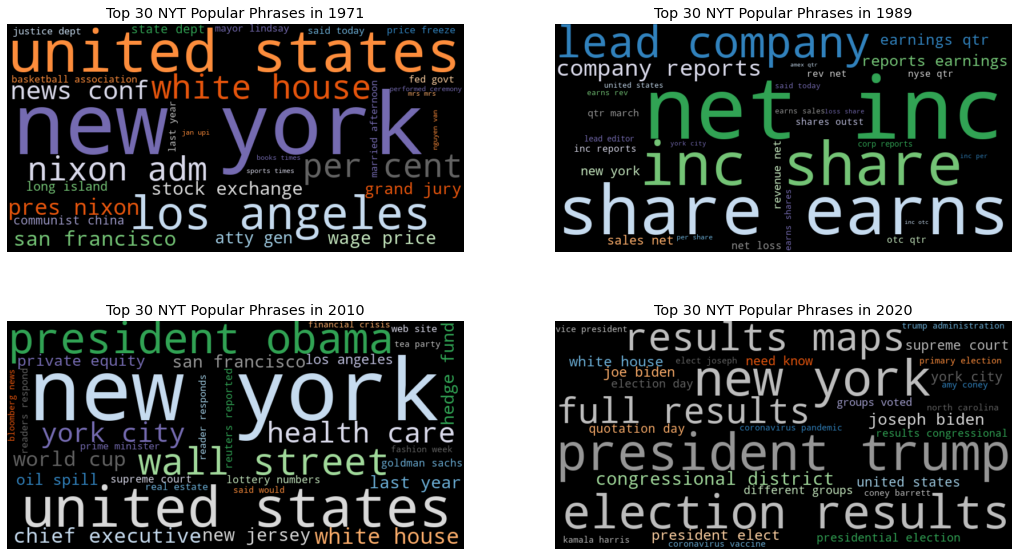

In [ ]:
plt.figure(figsize=(18, 10)) ###

plt.subplot(2,2,1)  #nrows, ncols, index
wordcloud(count_bigram_nyt1971, title='Top 30 NYT Popular Phrases in 1971', max_words=30, stopwords = stop_lst2)
plt.savefig("wordcloudNYT1971_bigram")

plt.subplot(2,2,2)  #nrows, ncols, index
wordcloud(count_bigram_nyt1989, title='Top 30 NYT Popular Phrases in 1989', max_words=30, background_color = "black", stopwords = stop_lst2)
plt.savefig("wordcloudNYT1989_bigram")

plt.subplot(2,2,3)  #nrows, ncols, index
wordcloud(count_bigram_nyt2010, title='Top 30 NYT Popular Phrases in 2010', max_words=30, background_color = "black", stopwords = stop_lst2)
plt.savefig("wordcloudNYT2010_bigram")

plt.subplot(2,2,4)  #nrows, ncols, index
wordcloud(count_bigram_nyt2020, title='Top 30 NYT Popular Phrases in 2020', max_words=30, background_color = "black", stopwords = stop_lst2)
plt.savefig("wordcloudNYT2020_bigram")


As we are seeing here, bigrams and single token shed light on what was popular in NYT and the society from different but also overlapping angles.

#### Bar Charts - How popular are these words/token?

Let's warm up with taking another look at our lovely `freq_word` and `freq_bigram` series data frames. For all 8 datasets, there is only one column (`Count`) and that `Token` is the name of the index, not a column. We shall pay attention to this when drawing our frequency barcharts in `Seaborn`, which provides a better alternative in visualization than Python-default `Matplotlib`.  

In [ ]:
freq_word_1971

,Count
Token,
says,16531
new,14766
today,8378
city,7453
state,7212
...,...
guide,100
tension,100
determination,100


Similar to how word maps are presented, 8 bar charts are arranged in two sets showing respectively the frequencies of tokens and bigrams. 

Seaborn Color Palette is referenced from this tutorial on [Code Academy](https://www.codecademy.com/article/seaborn-design-ii).

[Text(0.5, 0, '')]

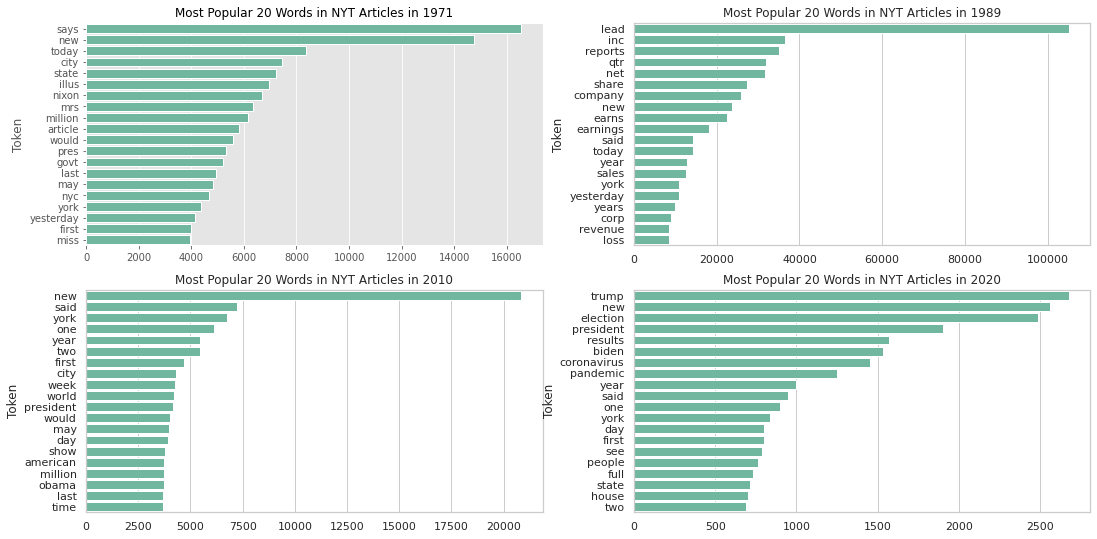

In [ ]:
import seaborn as sns
f, ax = plt.subplots(figsize=(18, 9))

plt.subplot(2,2,1)
sns.set_theme(style="whitegrid")
p1 = sns.barplot(y= freq_word_1971.head(20).index, x = "Count", data = freq_word_1971.head(20), palette = sns.color_palette('BuGn', 1))
p1.set_title("Most Popular 20 Words in NYT Articles in 1971")
p1.set(xlabel=None)

plt.subplot(2,2,2)
sns.set_theme(style="whitegrid")
p2 = sns.barplot(y= freq_word_1989.head(20).index, x = "Count", data = freq_word_1989.head(20), palette = sns.color_palette('BuGn', 1))
p2.set_title("Most Popular 20 Words in NYT Articles in 1989")
p2.set(xlabel=None)

plt.subplot(2,2,3)
sns.set_theme(style="whitegrid")
p3 = sns.barplot(y= freq_word_2010.head(20).index, x = "Count", data = freq_word_2010.head(20), palette = sns.color_palette('BuGn', 1))
p3.set_title("Most Popular 20 Words in NYT Articles in 2010")
p3.set(xlabel=None)

plt.subplot(2,2,4)
sns.set_theme(style="whitegrid")
p4 = sns.barplot(y= freq_word_2020.head(20).index, x = "Count", data = freq_word_2020.head(20), palette = sns.color_palette('BuGn', 1))
p4.set_title("Most Popular 20 Words in NYT Articles in 2020")
p4.set(xlabel=None)

Now let's look at bigrams/single phrases:

[Text(0, 0.5, '')]

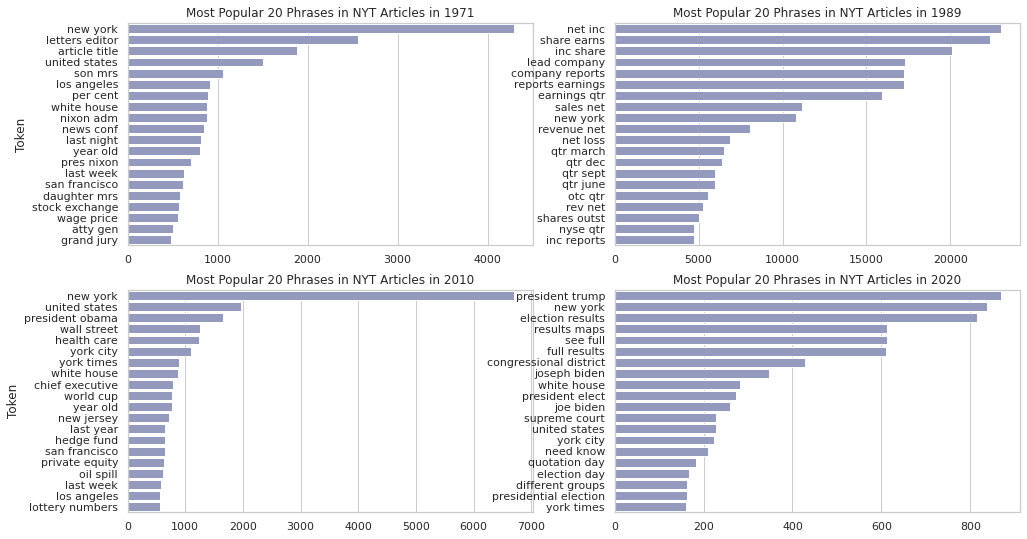

In [ ]:
f, ax = plt.subplots(figsize=(16, 9))

plt.subplot(2,2,1)
sns.set_theme(style="whitegrid")
g1 = sns.barplot(y= freq_bigram_1971.head(20).index, x = "Count", data = freq_bigram_1971.head(20), palette = sns.color_palette('BuPu', 1))
g1.set_title("Most Popular 20 Phrases in NYT Articles in 1971")
g1.set(xlabel=None)


plt.subplot(2,2,2)
sns.set_theme(style="whitegrid")
g2 = sns.barplot(y= freq_bigram_1989.head(20).index, x = "Count", data = freq_bigram_1989.head(20), palette = sns.color_palette('BuPu', 1))
g2.set_title("Most Popular 20 Phrases in NYT Articles in 1989")
g2.set(xlabel=None)
g2.set(ylabel=None)


plt.subplot(2,2,3)
sns.set_theme(style="whitegrid")
g3 = sns.barplot(y= freq_bigram_2010.head(20).index, x = "Count", data = freq_bigram_2010.head(20), palette = sns.color_palette('BuPu', 1))
g3.set_title("Most Popular 20 Phrases in NYT Articles in 2010")
g3.set(xlabel=None)

plt.subplot(2,2,4)
sns.set_theme(style="whitegrid")
g4 = sns.barplot(y= freq_bigram_2020.head(20).index, x = "Count", data = freq_bigram_2020.head(20), palette = sns.color_palette('BuPu', 1))
g4.set_title("Most Popular 20 Phrases in NYT Articles in 2020")
g4.set(xlabel=None)
g4.set(ylabel=None)


As they are showing, these two sets of bar charts reinforce our findings from wordmaps. 

#### Line Chart - How Has Popularity of Certain Key Words Evolve Over Time?

Now I will be marking a line chart that tells me how the popularity of certain key words in NYT articles changed over these four years. To do that, I first defined two sets of key words that I am interested in knowing about. Because criminal justice and k12 education are my top two issue interests, I have come up with five key words in each set. These key words are below 

In [ ]:
crime_keywords = ["crime", "police", "violence", "gun", "arrest"]
edu_keywords = ["education", "school", "teacher", "parent", "grade"]

Now I wrote a function that will find out the frequency of these key words in the dataset and compile them into a Pandas dataframe. The function has two attributes: `freq_nyt` (the name of the frequency table) and `keyword` (the set of the keyword).

In [ ]:
def get_key_word_df(freq_nyt, keyword):
  df1_0 = pd.DataFrame(freq_nyt.loc[keyword]).reset_index()
  df1_1 = pd.DataFrame(freq_nyt.loc[keyword]).reset_index()
  df1 = pd.concat([df1_0, df1_1])
  df1.reset_index().drop(columns = ["index"], inplace = True)
  df1.rename(columns = {"Token":"Keyword"})
  return df1


I realized that in year 2020, a lot of words of interests are not in the database, therefore, putting freq_word_2020 into the function will produce errors. I decide to leave this dataset alone and add it later

In [ ]:
kw_1971_crime = get_key_word_df(freq_word_1971, crime_keywords)
kw_1989_crime = get_key_word_df(freq_word_1989, crime_keywords)
kw_2010_crime = get_key_word_df(freq_word_2010, crime_keywords)

In [ ]:
kw_1971_edu = get_key_word_df(freq_word_1971, edu_keywords)
kw_1989_edu = get_key_word_df(freq_word_1989, edu_keywords)
kw_2010_edu = get_key_word_df(freq_word_2010, edu_keywords)
#kw_2020 = get_key_word_df(freq_word_2020, crime_keywords)

More data cleaning steps: concatenate these datasets into two larger data frames that we will be using later, add new columns, rename and reorder columns, and converting year and keyword to categories:

In [ ]:
crime_key_word = pd.concat([kw_1971_crime, kw_1989_crime, kw_2010_crime])
edu_key_word = pd.concat([kw_1971_edu, kw_1989_edu, kw_2010_edu])

In [ ]:
crime_key_word["year"] = [1971]*10 + [1989]*10 + [2010]*10
edu_key_word["year"] = [1971]*10 + [1989]*10 + [2010]*10

In [ ]:
crime_key_word["year"] = crime_key_word["year"].astype("category")
crime_key_word["Token"] = crime_key_word["Token"].astype("category")
crime_key_word = crime_key_word.rename(columns = {"Token":"Keyword"})
crime_key_word = crime_key_word.rename(columns = {"year":"Year"})

In [ ]:
edu_key_word["year"] = edu_key_word["year"].astype("category")
edu_key_word["Token"] = edu_key_word["Token"].astype("category")
edu_key_word = edu_key_word.rename(columns = {"Token":"Keyword"})
edu_key_word = edu_key_word.rename(columns = {"year":"Year"})

In [ ]:
crime_key_word = crime_key_word[['Year', 'Keyword', 'Count']] # rearrange order of columns
edu_key_word = edu_key_word[['Year', 'Keyword', 'Count']]

In [ ]:
edu_key_word["Year"] = edu_key_word["Year"].astype("category")
edu_key_word["Keyword"] = edu_key_word["Keyword"].astype("category")
#edu_key_word.rename(columns = {"Token":"Keyword"})

Now I manually appended the key word information of 2020 NYT articles to both data frames. 

In [ ]:
kw_2020_crime = pd.DataFrame({"Year": ["2020"]*5, "Keyword": crime_keywords, "Count": [0 ,290, 0, 0, 0]})
crime_key_word = crime_key_word.append(kw_2020_crime, ignore_index=True)

In [ ]:
kw_2020_edu = pd.DataFrame({"Year": ["2020"]*5, "Keyword": edu_keywords, "Count": [0 ,169, 0, 0, 0]})
edu_key_word = edu_key_word.append(kw_2020_edu, ignore_index=True)

After the operation, columns `Year` and `Keyword`'s data types have been distorted. I need to re-correct their datatypes and used `dtypes` function to make sure the correctness of data structure. 

In [ ]:
crime_key_word["Year"] = crime_key_word["Year"].astype("category")
crime_key_word["Keyword"] = crime_key_word["Keyword"].astype("category")

In [ ]:
edu_key_word["Year"] = edu_key_word["Year"].astype("category")
edu_key_word["Keyword"] = edu_key_word["Keyword"].astype("category")

Now we are good to go with drawing the line graph

In [ ]:
crime_key_word.dtypes

Year       category
Keyword    category
Count         int64
dtype: object

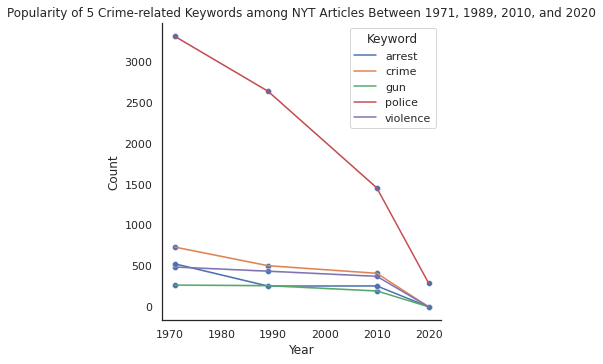

In [ ]:
sns.set_style("white")
sns.relplot(
    data=crime_key_word, x="Year", y="Count",
)

sns.lineplot(
    data=crime_key_word, x="Year", y="Count",
    hue="Keyword",
    legend="full"
).set_title("Popularity of 5 Crime-related Keywords among NYT Articles Between 1971, 1989, 2010, and 2020")
sns.despine()


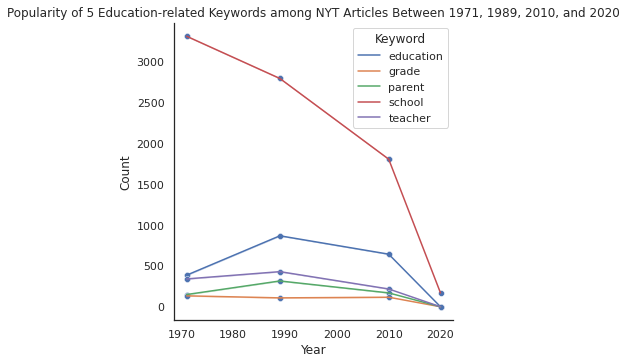

In [ ]:
sns.set_style("white")
sns.relplot(
    data=edu_key_word, x="Year", y="Count",
)

sns.lineplot(
    data=edu_key_word, x="Year", y="Count",
    hue="Keyword",
    legend="full"
).set_title("Popularity of 5 Education-related Keywords among NYT Articles Between 1971, 1989, 2010, and 2020")
sns.despine()

As we are able to see, out of these two sets, "school" and "police" occurred far more often than other words. These might be suggsting that NYT commonly published articles on policing and schooling as well as that other words in our keyword sets did not occur on NYT as frequently as these two can be explained from the angle that there are more alternatives to these words than "school" and "police" because English is a flexible language and there usually has more than one way to convey a meaning. 

Moreover, regardless of the time, the frequency of both "police" and "school" went straightly down from very high points in 1971 all the way to where they were in 2020. This pattern is not yet found for other words or not that evident. This is an interesting finding, and the reason of which shall be further investigated.

Lastly, year 2020 is a special point because words "education", "crime", etc. are not in the database, and the total word count is much lower than the counts of other years' archived data (# observation is roughly 10 times smaller than # observations in other years' NYT datasets). The degree to which the difference in data size impacts the accuracy of our visual finding is unknown.   

### Part IV: Data Modeling - Clustering and Grouping
---

In the last section, I will be using clustering and deep learning to perform text clustering and visualize the clusters. 

First, we load libraries:

In [13]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

For the convenience of our model running, I concated four cleaned datasets and sampled 1000 observations from them. The randomly sampled data will be used to do machine learning. 

In [23]:
NYT_data = pd.concat([NYT_1971, NYT_1989, NYT_2010, NYT_2020]).reset_index()

In [24]:
NYT_data  = NYT_data.drop(columns = ["index"])
NYT_data["year"]  = NYT_data["year"].astype("category")

In [25]:
NYT_data.dtypes

year                  category
sentence                object
sentence processed      object
sentence tokenized      object
sentence bigrammed      object
dtype: object

In [48]:
NYT_data.tail(5)

,year,sentence,sentence processed,sentence tokenized,sentence bigrammed
324889,2020,We talked to the Broadway stars behind a virtu...,talked broadway stars behind virtual performan...,"[talked, broadway, stars, behind, virtual, per...","[talked broadway, broadway stars, stars behind..."
324890,2020,"Make yourself a Grown-Up Granita. For dinner, ...",make grown granita dinner may suggest steak po...,"[make, grown, granita, dinner, may, suggest, s...","[make grown, grown granita, granita dinner, di..."
324891,2020,The hackers gained more access than the compan...,hackers gained access company previously revea...,"[hackers, gained, access, company, previously,...","[hackers gained, gained access, access company..."
324892,2020,Six new paperbacks to check out this week. New...,six new paperbacks check week new paperback re...,"[six, new, paperbacks, check, week, new, paper...","[six new, new paperbacks, paperbacks check, ch..."
324893,2020,After a year punctuated by a pandemic and unem...,year punctuated pandemic unemployment cities a...,"[year, punctuated, pandemic, unemployment, cit...","[year punctuated, punctuated pandemic, pandemi..."


In [26]:
data = NYT_data.sample(n = 1000)
#X = data["sentence processed"]
#y = data["year"]


In [ ]:
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=42)

In [27]:
NYT_clustering = data

#### 1. K-means Clustering with Tf-IDF

We will be using a few clustering algorithms for this section. We start with the basics and the mostly commonly used algorithm- kmeans, which is a simple but powerful and effective way to cluster simple text data. For k-means, the **tf-idf** score will be used as the metric for clustering. Tf-idf, as compared to other string similarity methods, emphasize the popularity of a specific word/token both within an document and across different documents. The more times one word appear in one article and across multiple articles, the higher the score. To do the clustering, we will be replying on functions from our beloved `sklearn` library.

First, we counted the tf-idf score of each token.

In [28]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X_clustering = vectorizer.fit_transform(NYT_clustering['sentence processed'])

Now, we apply kmean algorithm to out data. For simplicity, I set the number of desired clusters to 5, but the number could be higher or lower than this.

In [29]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_clustering)
clusters = kmeans.labels_

In [49]:
X_clustering.shape

(1000, 951)

Because our X is a high-dimension data (1000 rows * 951 columns), we will be using Principal Component Analysis to reduce its dimension while also preserving the relationship between data. For PCA, two vectors are usually sufficient. This is easily done below.

In [30]:
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X_clustering.toarray())
x0_clustering = pca_vecs[:, 0]
x1_clustering = pca_vecs[:, 1]

In [41]:
NYT_clustering['Cluster'] = clusters
NYT_clustering['X0'] = x0_clustering
NYT_clustering['X1'] = x1_clustering

The following function attrives the top 20 key word inside each cluster:

In [32]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X_clustering.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print(f"\nCluster No.{i}")
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(20)


Cluster No.0
former,life,house,art,city,news,american,day,article,time,people,business,may,two,president,one,says,said,today,lead

Cluster No.1
shares,rev,june,sept,outst,dec,otc,lead,loss,sales,corp,revenue,company,earnings,earns,share,inc,net,reports,qtr

Cluster No.2
seeks,latest,sports,gas,open,trade,coach,magazine,full,make,americans,example,chance,james,report,day,adm,lead,letters,editor

Cluster No.3
many,word,department,taking,study,american,mayor,street,two,john,white,yesterday,back,jersey,last,times,lead,city,york,new

Cluster No.4
robert,state,one,new,today,miss,daughter,died,son,said,last,married,yesterday,first,home,years,mrs,old,lead,year


Now we give each cluster a label and visualize clusters with a scatterplot implemented through the `seaborn` library. 

In [ ]:
cluster_label = {0: "Politics", 1: "Business and Finance", 2: "Sport and Life", 3: "City and World", 4: "Misc"}

NYT_clustering['Cluster'] = NYT_clustering['Cluster'].map(cluster_label)

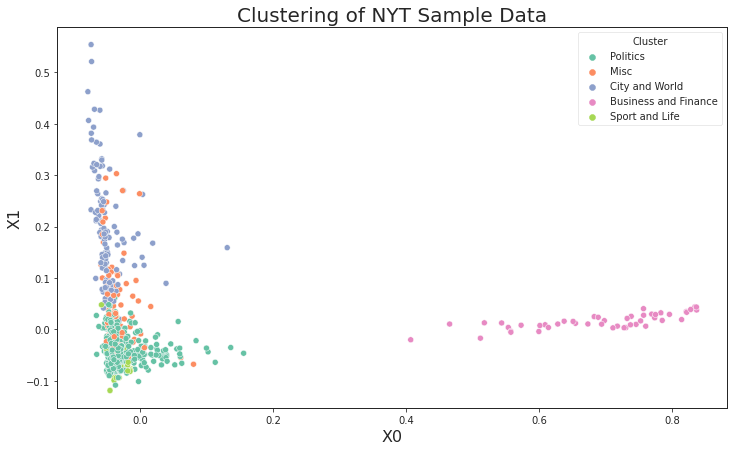

In [45]:
plt.figure(figsize=(12, 7))
# set a title
plt.title("Clustering of NYT Sample Data", fontdict={"fontsize": 20})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data= NYT_clustering, x='X0', y='X1', hue='Cluster', palette="Set2")
plt.show()

As we are able to tell, K-means is not really what we desired. Clusters collapsed on each other and are hard to be separated. Because of the overlapping, we can hardly see which cluster belongs to which. We, hereby, should consider other algorithms, which can better capture the complexity of our data, for this task. 

#### 2. Word2Vec

In [17]:
!cat /proc/meminfo

MemTotal:       13298580 kB
MemFree:         8217844 kB
MemAvailable:    9935300 kB
Buffers:           87152 kB
Cached:          1477288 kB
SwapCached:            0 kB
Active:          3292244 kB
Inactive:        1507600 kB
Active(anon):    2889852 kB
Inactive(anon):      444 kB
Active(file):     402392 kB
Inactive(file):  1507156 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               436 kB
Writeback:             0 kB
AnonPages:       3235408 kB
Mapped:           521156 kB
Shmem:              1212 kB
KReclaimable:      98720 kB
Slab:             148804 kB
SReclaimable:      98720 kB
SUnreclaim:        50084 kB
KernelStack:        5104 kB
PageTables:        26536 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6649288 kB
Committed_AS:    4959460 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       47184 kB
VmallocChunk:          0 kB
Percpu:          